In [8]:
from transformers import pipeline
import torch
import numpy as np

device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)
# if it is not MPS, try CUDA
#device = torch.device("cuda") if torch.cuda.is_available() else device
print(f"Using device: {device}")

Using device: cpu


In [41]:
def set_seed(seed):
    torch.manual_seed(seed)
    # random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPUs

set_seed(4242)

### Task 1: Sentiment Analysis
Sentiment Analysis is the task of classifying a given text into positive, negative, or neutral sentiments.

In this example, we will use a pre-trained model for sentiment analysis. The `pipeline` will automatically download and load a model that has been pre-trained on a large dataset to perform this task.

In [12]:
#model_name = "ncbi/MedCPT-Article-Encoder"
model_name = "bert-base-uncased"


classifier = pipeline("sentiment-analysis", model=model_name, device=device)
result = classifier(
    "The development of a recombinant polyclonal antibody therapy for COVID-19 by GigaGen represents an early-stage positive news in response to a global health crisis. However, such initiatives often come with high risk and uncertainty given the complexity and time required for clinical trials and approval processes. Additionally, competition in the COVID-19 treatment space is intense, with many companies pursuing similar therapies. These factors make it essential to remain cautious, monitoring further developments and data closely."
)

print(f"Sentiment Analysis Result: {result}")

c:\.UNI\LTP\.venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\12saw\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initia

Sentiment Analysis Result: [{'label': 'LABEL_0', 'score': 0.6011013984680176}]


# 3. Fine-Tuning Pre-trained Models
While the pre-trained models provided by Hugging Face are powerful, you may want to fine-tune them for a specific task or dataset.

Fine-tuning involves taking a pre-trained model and training it further on your own data. This can improve the model’s performance for specific use cases.

For this section, we’ll load the IMDB dataset (which contains movie reviews) and fine-tune a pre-trained model for sentiment classification.

### Step 1: Load Dataset
We'll use Hugging Face's datasets library to load the IMDB dataset.

Datasets from the dataset library often come with pre-defined splits of the data, such as `train` and `test` sets.

It is possible to filter or slice datasets to focus on specific subsets of the data, using the `select` method.

In [ ]:
from datasets import load_dataset, Features, ClassLabel, Value
import os, sys

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
data_file_path = os.path.join(parentdir, "data/processed/finetuning-3label.csv")
if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"The file {data_file_path} does not exist!")

# Define the features
features = Features(
    {
        "text": Value("string"),
        "labels": ClassLabel(names=["0", "1", "2"]),
    }
)

# Load the dataset with the specified features
dataset = load_dataset(
    "csv",
    data_files=data_file_path,
    features=features,
)


#Now you can stratify by 'labels'
#split_dataset = dataset["train"].train_test_split(
#    test_size=0.1, stratify_by_column="labels"
#)
#train_dataset = split_dataset["train"]
#test_dataset = split_dataset["test"]

**Train Test Split**

In [ ]:
#add a columns "id" with a unique row id
dataset["train"] = dataset["train"].add_column("id", range(len(dataset["train"])))

In [98]:
print(dataset)
print(dataset["train"][1])

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 3880
    })
})
{'text': 'GigaGen to Present at the Inaugural LifeSci Partners Private Company Virtual Summer Symposium SOUTH SAN FRANCISCO, Calif., July  29, 2020  (GLOBE NEWSWIRE) -- GigaGen Inc., a biotechnology company advancing transformative antibody drugs for infectious diseases, transplant rejection and checkpoint resistant cancers, today announced that it will participate in the LifeSci Partners Private Company Virtual Summer Symposium, taking place on August 4-5, 2020.', 'labels': 1, 'id': 1}


In [101]:
from sklearn.model_selection import train_test_split

labels = np.array(dataset["train"]["labels"])

# Generate indices for stratified split
indices = np.arange(len(labels))
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.1,
    stratify=labels,
    random_state=42,  # Ensures reproducibility
)

# Create stratified train and test datasets, remember its a pandas dataframe
train_dataset = dataset["train"].select(train_indices)
test_dataset = dataset["train"].select(test_indices)

In [106]:
test_dataset[0]

{'text': 'Pacira Appoints Frank D. Lee as Chief Executive Officer -- Transformational Leader Brings Three Decades of Global Experience in Pharmaceutical and Biotechnology Product Development and Commercialization\xa0-- -- Paul J. Hastings Named Chair of the Board --',
 'labels': 1,
 'id': 989}

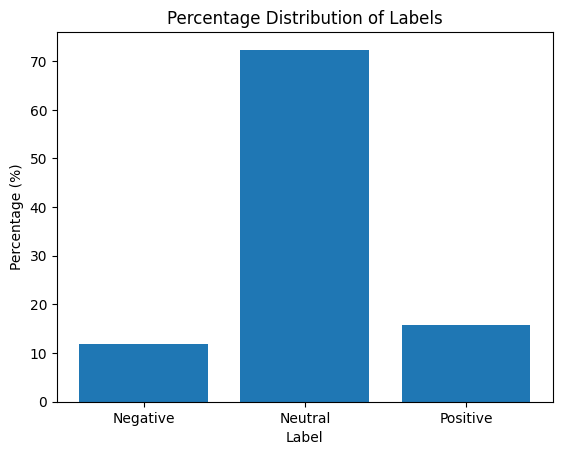

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming labels is a numpy array of your dataset labels
labels = np.array(dataset["train"]["labels"])
label_counts = np.bincount(labels)
label_percentages = label_counts / label_counts.sum() * 100  # Convert counts to percentages

# Define label names
label_names = ["Negative", "Neutral", "Positive"]

# Plot the histogram
plt.bar(range(len(label_percentages)), label_percentages)
plt.xlabel("Label")  # Set the x-axis label
plt.ylabel("Percentage (%)")  # Set the y-axis label
plt.title("Percentage Distribution of Labels")  # Set the title
plt.xticks(range(len(label_percentages)), label_names)  # Map labels to names
plt.show()


Text(0.5, 1.0, 'Distribution of Text Lengths')

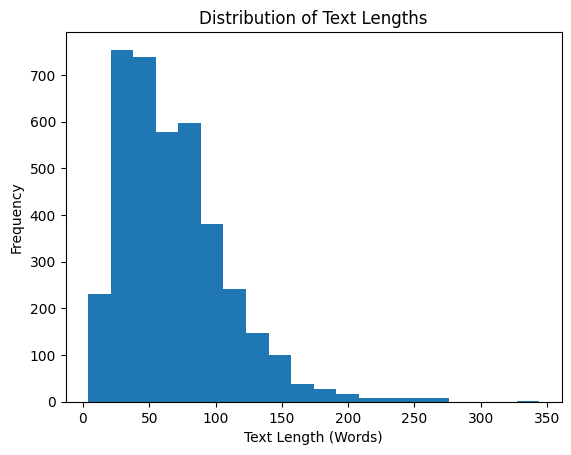

In [114]:
#now plot the distribution of text lengths by words

text_lengths = [len(text.split()) for text in dataset["train"]["text"]]
plt.hist(text_lengths, bins=20)
plt.xlabel("Text Length (Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")   

### Step 2: Tokenize the Dataset
The dataset needs to be tokenized before it can be fed into the model. Tokenization converts the text data into numerical format (tokens) that the model can process.

We'll use the `AutoTokenizer` class from HuggingFace to tokenize the data. The `AutoTokenizer` class automatically selects the appropriate tokenizer for the model based on the `model_name`.

Tokenization or transformation of the dataset can be done using the `map` method, which applies a function to all the elements of the dataset. This is easily done by defining a function that tokenizes the text data and then applying it to the dataset. When `batched=True`, the function will be applied to batches of data, which can improve performance by applying the function in parallel.

In [115]:
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer, padding="max_length", max_length=512
)


def tokenize_function(examples):
    # print(examples["text"][0])
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)


tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 388/388 [00:00<00:00, 1619.63 examples/s]


In [116]:
tokenized_test


Dataset({
    features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 388
})

### Step 3: Load a Pre-trained Model
Now that the data is tokenized, we'll load a pre-trained model that we'll fine-tune for sentiment classification.

We'll use distilbert-base-uncased for this task.

We need to import `AutoModelForSequenceClassification` for that. The key feature of this class is that it adds a classification head on top of the pre-trained transformer model to allow it to classify sequences into one or more categories (e.g., positive/negative sentiment, spam/ham, etc.). The `from_pretrained` method loads the pre-trained model with the specified configuration. The `num_labels` parameter specifies the number of labels in the classification task (binary in this case).

In [117]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, # ignore_mismatched_sizes=True
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 4: Set Up the Trainer
Hugging Face provides the Trainer class to help with the training and fine-tuning of models. We need to set up the trainer by providing the model, training arguments, and the datasets.


In [118]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted", labels=[0, 1, 2]
    )
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [119]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(dataset["train"]["labels"]),
    y=dataset["train"]["labels"],
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

Class Weights: tensor([2.8055, 0.4608, 2.1133])


In [120]:
import torch.nn as nn
import torch.nn.functional as F


# Define custom loss function
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.class_weights = class_weights

    def forward(self, logits, labels):
        return F.cross_entropy(logits, labels, weight=self.class_weights)

In [121]:
from transformers import Trainer, TrainingArguments


# Define custom trainer
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Move class_weights to the same device as logits
        loss_fct = WeightedCrossEntropyLoss(self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [122]:
training_args = TrainingArguments(
    output_dir="./results",  # Output directory
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",
    learning_rate=2e-5,  # Learning rate
    per_device_train_batch_size=8,  # Batch size for training
    per_device_eval_batch_size=8,  # Batch size for evaluation
    num_train_epochs=10,  # Number of epochs
    weight_decay=0.001,  # Strength of weight decay
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="f1",  # Use F1 score to select the best model
    save_total_limit=1,  # Limit the total amount of checkpoints
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train, 
    eval_dataset=tokenized_test,  
    compute_metrics=compute_metrics,
    class_weights=class_weights,  
    data_collator=data_collator,
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

### Step 5: Fine-tune the Model
Now that the trainer is set up, we can start the fine-tuning process.

Run the following cell to fine-tune the model.

In [ ]:
trainer.train()

### Step 6: Evaluate the Model
After training, we can evaluate the model’s performance on the test set.

In [ ]:
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

### Step 7: Try out model

In [ ]:
input_string = "BioVie Announces Alignment with FDA on Clinical Trial to Assess Bezisterim in Parkinson’s Disease,SUNRISE-PD to evaluate the effect of bezisterim (NE3107) on motor and non-motor symptoms in ~60 patients with Parkinson’s disease who are naïve to carbidopa/levodopa,SUNRISE-PD to evaluate the effect of bezisterim (NE3107) on motor and non-motor symptoms in ~60 patients with Parkinson’s disease who are naïve to carbidopa/levodopa"

# Tokenize the input string
inputs = tokenizer(input_string, return_tensors="pt").to(device)

# Get predictions (logits)
with torch.no_grad():  # Disable gradient computation since we're just doing inference
    outputs = model(**inputs)
    logits = outputs.logits
print(logits)
predicted_label = torch.argmax(logits, dim=1).item()


print(f"Predicted label: {predicted_label}")

### Step 8. Saving the Fine-tuned Model
After training, it is often useful to save the fine-tuned model, so you can use it later without needing to re-train it.

In [ ]:
model.push_to_hub(
    f"akseljoonas/MedCPT-Article-Encoder-finetuned-{eval_results['f1']:.3f}"
)
tokenizer.push_to_hub(
    f"akseljoonas/MedCPT-Article-Encoder-finetuned-{eval_results['f1']:.3f}"
)